# Figures with Dynamics

This notebook provides figures relating to the *dynamics* of the model (Fig. 2 and Fig. S1). Figures related to *inference* are handled in separate notebooks for each data set (`math_PhD.ipynb`,`parakeet.ipynb`, and `newcomb_frat.ipynb`). 

In [1]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *
from py.utils import *
# from SpringRank import SpringRank

from matplotlib import pyplot as plt

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"
matplotlib.rcParams['mathtext.fontset'] = "dejavusans"

# Setup: 

In [2]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

In [3]:
@jit(nopython=True)
def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

/Users/MariKawakatsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/Users/MariKawakatsu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:200: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


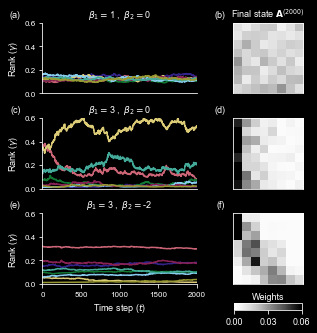

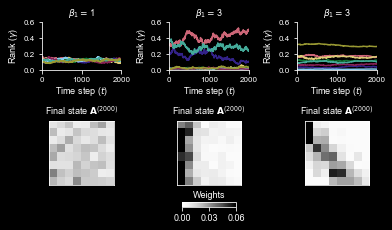

In [13]:
# Generate Fig. 2 (manuscript and preprint versions)
plt.style.use('dark_background')

np.random.seed(seed=6)

BETA_1 = np.array([1,3,3])
BETA_2 = np.array([0,0,-2])

highlight_col = 0

lam = .995
n_rounds = 4000
m_updates = 1

n = 8
A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

ymax = 0.6
ymin = 0

fontsize = 9

######################
# Manuscript version #
######################
fig, axarr = plt.subplots(len(BETA_1),2, # len(BETA_2)*2, 
                          gridspec_kw={'width_ratios': [0.4, 1]},
                          figsize = (6/0.8, 1.6*len(BETA_1)))

for i in range(len(BETA_1)):
#     for j in range(len(BETA_2)): #v2
    for j in range(1): #v3/4

        row_num = i
        col_num = j
        
        ax = axarr[row_num,col_num]
        beta_1 = BETA_1[row_num]
#         beta_2 = BETA_2[col_num] #v2
        beta_2 = BETA_2[row_num] #v3/4

        M = model()
        M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
        M.set_features([linear_feature, 
                        quadratic_feature])

        M.simulate(beta      = np.array([beta_1, beta_2]), 
                   lam       = lam, 
                   A0        = A0, 
                   n_rounds  = n_rounds, 
                   update    = stochastic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()
        
        for k in range(n):
            p = ax.plot(GAMMA.mean(axis = 1)[np.int(n_rounds/2):,k], color = cset_muted[k])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set(ylim = (ymin, ymax))
        ax.set(xlim = (0, np.int(n_rounds/2)))
        ax.tick_params(labelsize=fontsize-1)

        
        if row_num < len(BETA_1)-1:
#             ax.spines['bottom'].set_visible(False)
            ax.xaxis.set_ticks([])
            plt.xticks([])

        if col_num > 0:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks([])
            plt.yticks([])

        if row_num == len(BETA_1)-1:
            ax.set_xlabel(xlabel = r'Time step ($t$)', fontsize=fontsize)
        if col_num == 0:
            ax.set_ylabel(ylabel = r'Rank ($\gamma$)', fontsize=fontsize)
        
        ax.set_title(
            r'$\beta_1 = $' + str(round(beta_1,2)) + r'$\;$,$\;$ $\beta_2 = $' + str(round(beta_2,2)), #v3/4
#             r'$\beta_1 = $' + str(round(beta_1,2)), #v2
            fontsize=fontsize
        )
        
        if col_num == highlight_col:
            ax2 = axarr[row_num,highlight_col+1]
            A = M.get_states()[-1]

            v = GAMMA[-1].mean(axis = 0) 
#             ax.imshow(np.ones_like(A), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
            im = ax2.imshow(matrix_sort(A, -v), vmin = 0., vmax = .06,  cmap = 'Greys', alpha = .99)
#             axarr[j,3].axis('off')
#             ax.set_ylabel(r'$\longrightarrow$', rotation=0, fontsize=20, labelpad=30, color = 'black')
            for pos in ['bottom', 'top', 'left', 'right']:
                ax2.spines[pos].set_visible(True)
            ax2.xaxis.set_ticks([])
            ax2.yaxis.set_ticks([])

# axarr[0,len(BETA_2)].set_title('Final State')
axarr[0,1].set_title(r'Final state $\mathbf{A}^{(2000)}$', fontsize=fontsize)

# add colorbar
cbar_ax = fig.add_axes([0.48, 0.05, 0.125, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_clim(0.0,0.06)
cbar.set_ticks([0.00,0.03,0.06])
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_title('Weights',fontsize=fontsize,y=0.65)
cbar_ax.xaxis.set_ticks_position('bottom')

# add panel labels
for i, label in enumerate(('(a)','(b)','(c)','(d)','(e)','(f)')):
    ax = axarr[i//2,i%2]
    hloc = -0.175 + 0.035*(i%2+1)
    vloc = 1.185
    ax.text(hloc, vloc, label, transform=ax.transAxes,
      fontsize=fontsize, weight='bold', va='top', ha='right')

# adjust spacing
plt.subplots_adjust(wspace = -0.45, hspace = 0.35)

# plt.savefig('fig/dynamics_examples_v4.png', bbox_inches = 'tight', dpi = 600)

#####################
# Preprint version #
#####################
fig, axarr = plt.subplots(2,len(BETA_1), # len(BETA_2)*2, 
                          gridspec_kw={'height_ratios': [0.75, 1]},
                          figsize = (2*len(BETA_1),3))

for i in range(len(BETA_1)):
    for j in range(1):

        row_num = j
        col_num = i
        
        ax = axarr[row_num,col_num]
        beta_1 = BETA_1[col_num]
        beta_2 = BETA_2[col_num]

        M = model()
        M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
        M.set_features([linear_feature, 
                        quadratic_feature])

        M.simulate(beta      = np.array([beta_1, beta_2]), 
                   lam       = lam, 
                   A0        = A0, 
                   n_rounds  = n_rounds, 
                   update    = stochastic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()
        
        for k in range(n):
            p = ax.plot(GAMMA.mean(axis = 1)[np.int(n_rounds/2):,k], color = cset_muted[k])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set(ylim = (ymin, ymax))
        ax.set(xlim = (0, np.int(n_rounds/2)))
        ax.tick_params(labelsize=fontsize-1)
        
        if row_num > 0:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks([])
            plt.yticks([])

        ax.set_xlabel(xlabel = r'Time step ($t$)', fontsize=fontsize)
        ax.xaxis.set_label_coords(0.5,-0.3)
        
#         if col_num == 0:
        ax.set_ylabel(ylabel = r'Rank ($\gamma$)', fontsize=fontsize)
        ax.yaxis.set_label_coords(-0.27,0.5)
        
        ax.set_title(
#             r'$\beta_1 = $' + str(round(beta_1,2)) + r'$\;$,$\;$ $\beta_2 = $' + str(round(beta_2,2)), #v3/4
            r'$\beta_1 = $' + str(round(beta_1,2)), #v2
            fontsize=fontsize
        )
        
        ax2 = axarr[row_num+1,col_num]
        A = M.get_states()[-1]

        v = GAMMA[-1].mean(axis = 0) 
        im = ax2.imshow(matrix_sort(A, -v), vmin = 0., vmax = .06,  cmap = 'Greys', alpha = .99)
        for pos in ['bottom', 'top', 'left', 'right']:
            ax2.spines[pos].set_visible(True)
        ax2.xaxis.set_ticks([])
        ax2.yaxis.set_ticks([])
        
        ax2.set_title(r'Final state $\mathbf{A}^{(2000)}$', fontsize=fontsize)

# add colorbar
cbar_ax = fig.add_axes([0.45, 0.025, 0.125, 0.02])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_clim(0.0,0.06)
cbar.set_ticks([0.00,0.03,0.06])
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_title('Weights',fontsize=fontsize,y=0.65)
cbar_ax.xaxis.set_ticks_position('bottom')

# add panel labels
# for i, label in enumerate(('(a)','(b)','(c)','(d)','(e)','(f)')):
#     ax = axarr[i%2,i//2]
#     hloc = -0.175 - 0.035*((i+1)%2)
#     vloc = 1.20 + 0.07*((i+1)%2)
#     ax.text(hloc, vloc, label, transform=ax.transAxes,
#       fontsize=fontsize, weight='bold', va='top', ha='right')

# adjust spacing
plt.subplots_adjust(wspace = 0.6, hspace = 0.9)

plt.savefig('img/dynamics_examples_dark.png', bbox_inches = 'tight', dpi = 600)

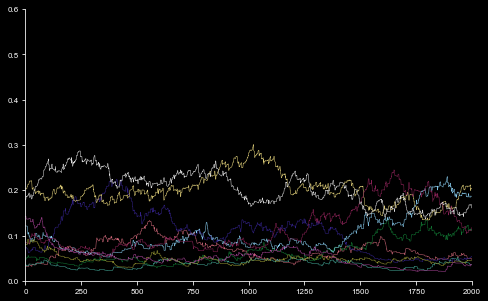

In [38]:
# Generate Fig. 2 (manuscript and preprint versions)
plt.style.use('dark_background')

np.random.seed(seed=6)

BETA_1 = np.array([2.1])
BETA_2 = np.array([0])

highlight_col = 0

lam = .995
n_rounds = 4000
m_updates = 1

n = 10
A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

ymax = 0.6
ymin = 0

fontsize = 9

#####################
# Preprint version #
#####################
fig, ax = plt.subplots(figsize = (8*len(BETA_1),5))

for i in range(len(BETA_1)):
    for j in range(1):

        row_num = j
        col_num = i
                
        beta_1 = BETA_1[col_num]
        beta_2 = BETA_2[col_num]

        M = model()
        M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
        M.set_features([linear_feature, 
                        quadratic_feature])

        M.simulate(beta      = np.array([beta_1, beta_2]), 
                   lam       = lam, 
                   A0        = A0, 
                   n_rounds  = n_rounds, 
                   update    = stochastic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()
        
        for k in range(n):
            p = ax.plot(GAMMA.mean(axis = 1)[np.int(n_rounds/2):,k], color = cset_muted[k], linewidth=0.5)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set(ylim = (ymin, ymax))
        ax.set(xlim = (0, np.int(n_rounds/2)))
        ax.tick_params(labelsize=fontsize-1)
        
#         if row_num > 0:
#             ax.spines['left'].set_visible(False)
#             ax.yaxis.set_ticks([])
#             plt.yticks([])

#         ax.set_xlabel(xlabel = r'Time step ($t$)', fontsize=fontsize)
#         ax.xaxis.set_label_coords(0.5,-0.3)
        
#         if col_num == 0:
#         ax.set_ylabel(ylabel = r'Rank ($\gamma$)', fontsize=fontsize)
#         ax.yaxis.set_label_coords(-0.27,0.5)
        
#         ax.set_title(
# #             r'$\beta_1 = $' + str(round(beta_1,2)) + r'$\;$,$\;$ $\beta_2 = $' + str(round(beta_2,2)), #v3/4
#             r'$\beta_1 = $' + str(round(beta_1,2)), #v2
#             fontsize=fontsize
#         )
        
# adjust spacing
plt.subplots_adjust(wspace = 0.6, hspace = 0.9)

plt.savefig('img/dynamics_examples_dark_large.png', bbox_inches = 'tight', dpi = 600)